In [ ]:
!pip install tensorflow


c:\Users\SujanRam\OneDrive\Documents\pyhton\venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


File not found: synthetic_dataset.csv. Creating a sample dataset.
Episode 0, Action 0, Reward: -0.3302, Epsilon: 0.9950
Episode 10, Action 1, Reward: -0.3036, Epsilon: 0.9464
Episode 20, Action 2, Reward: -0.4421, Epsilon: 0.9001
Episode 30, Action 4, Reward: -0.6616, Epsilon: 0.8561
Episode 40, Action 0, Reward: -0.5775, Epsilon: 0.8142
Episode 50, Action 0, Reward: -0.5656, Epsilon: 0.7744
Episode 60, Action 1, Reward: -0.5588, Epsilon: 0.7366
Episode 70, Action 4, Reward: -0.9778, Epsilon: 0.7005
Episode 80, Action 0, Reward: -1.1328, Epsilon: 0.6663
Episode 90, Action 2, Reward: -0.6253, Epsilon: 0.6337
Episode 100, Action 1, Reward: -0.8327, Epsilon: 0.6027
Episode 110, Action 1, Reward: -1.5905, Epsilon: 0.5733
Episode 120, Action 2, Reward: -2.6864, Epsilon: 0.5452
Episode 130, Action 1, Reward: -3.5132, Epsilon: 0.5186
Episode 140, Action 3, Reward: -4.5475, Epsilon: 0.4932
Episode 150, Action 1, Reward: -3.2373, Epsilon: 0.4691
Episode 160, Action 4, Reward: -3.3626, Epsilon: 

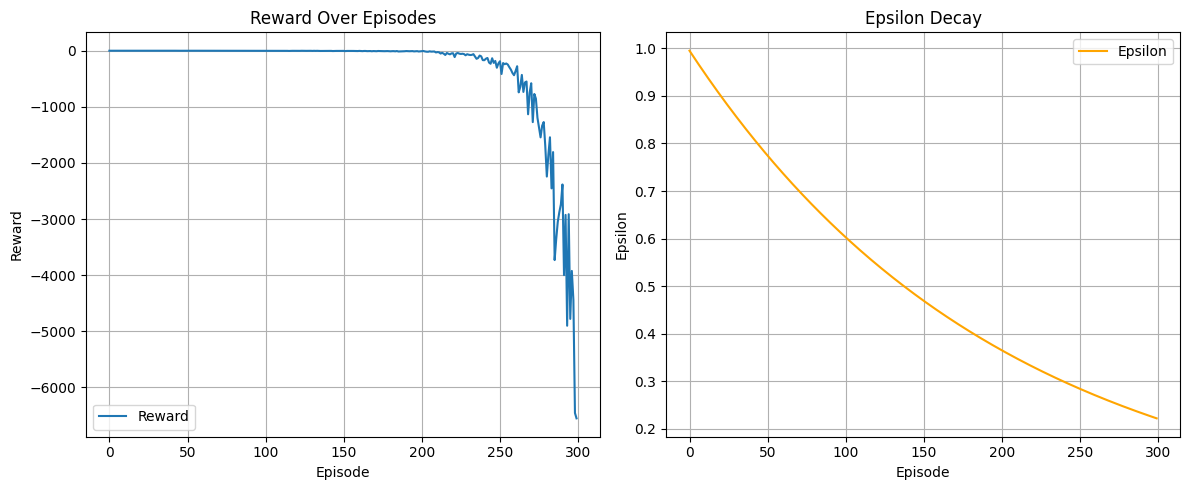

In [1]:
import numpy as np
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt
import pandas as pd
import os

# Constants
STATE_DIM = 10   # Number of features
ACTION_DIM = 5   # Number of labels
LEARNING_RATE = 0.001
GAMMA = 0.99
EPSILON = 1.0
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01
MEMORY_SIZE = 10000
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = 100
MAX_EPISODES = 300


# Initialize the DNN model
def initialize_dnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(STATE_DIM,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(ACTION_DIM, activation='linear')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='mse'
    )
    return model


# Custom DataStream Class
class CustomDataStream:
    def __init__(self, path='synthetic_dataset.csv'):
        if not os.path.exists(path):
            print(f"File not found: {path}. Creating a sample dataset.")
            sample_data = pd.DataFrame(
                np.random.rand(100, 15),
                columns=[f"col_{i}" for i in range(15)]
            )
            sample_data.to_csv(path, index=False)

        data = pd.read_csv(path)
        self.X = data.iloc[:, :10].values     # Features
        self.y = data.iloc[:, 10:].values    # Labels
        self.index = 0
        self.n_samples = len(self.X)
        self.features = self.X[self.index]
        self.label = self.y[self.index]

    def next(self):
        self.index = (self.index + 1) % self.n_samples
        self.features = self.X[self.index]
        self.label = self.y[self.index]
        return self

    def get_feedback(self):
        return {'performance': np.random.rand()}  # Simulated feedback


# Reward function
def compute_reward(prediction, true_label):
    return -np.mean((prediction - true_label) ** 2)


# Execute chosen action
def execute_action(action, data_stream, q_network):
    global LEARNING_RATE

    if action == 0:
        LEARNING_RATE *= 0.9
    elif action == 1:
        LEARNING_RATE *= 1.1

    prediction = q_network.predict(
        data_stream.features[np.newaxis, :],
        verbose=0
    )[0]

    reward = compute_reward(prediction, data_stream.label)
    next_state = data_stream.next().features

    return reward, next_state


# Incorporate feedback
def incorporate_feedback(feedback, feedback_history):
    global LEARNING_RATE
    feedback_history.append(feedback)
    if feedback['performance'] < 0.5:
        LEARNING_RATE *= 0.95


def analyze_feedback_trends(feedback_history):
    global EPSILON
    if len(feedback_history) >= 100:
        avg_perf = np.mean(
            [f['performance'] for f in feedback_history[-100:]]
        )
        if avg_perf > 0.8:
            EPSILON = max(EPSILON_MIN, EPSILON * 0.9)


# Main training loop
def main():
    global EPSILON

    q_network = initialize_dnn()
    target_network = initialize_dnn()
    target_network.set_weights(q_network.get_weights())

    replay_memory = deque(maxlen=MEMORY_SIZE)
    feedback_history = []
    data_stream = CustomDataStream()

    reward_history = []
    epsilon_history = []

    for episode in range(MAX_EPISODES):
        state = np.array(data_stream.features)

        if np.random.rand() < EPSILON:
            action = random.randint(0, ACTION_DIM - 1)
        else:
            q_values = q_network.predict(state[np.newaxis, :], verbose=0)[0]
            action = np.argmax(q_values)

        reward, next_state = execute_action(action, data_stream, q_network)
        replay_memory.append((state, action, reward, next_state))

        if len(replay_memory) >= BATCH_SIZE:
            batch = random.sample(replay_memory, BATCH_SIZE)
            states, actions, rewards_batch, next_states = zip(*batch)

            states = np.array(states)
            next_states = np.array(next_states)
            rewards_batch = np.array(rewards_batch)

            next_q_values = target_network.predict(next_states, verbose=0)
            targets = rewards_batch + GAMMA * np.max(next_q_values, axis=1)

            q_values = q_network.predict(states, verbose=0)
            for i, a in enumerate(actions):
                q_values[i][a] = targets[i]

            q_network.fit(states, q_values, epochs=1, verbose=0)

        feedback = data_stream.get_feedback()
        if feedback:
            incorporate_feedback(feedback, feedback_history)
            analyze_feedback_trends(feedback_history)

        EPSILON = max(EPSILON_MIN, EPSILON * EPSILON_DECAY)

        if episode % TARGET_UPDATE_FREQ == 0:
            target_network.set_weights(q_network.get_weights())

        reward_history.append(reward)
        epsilon_history.append(EPSILON)

        if episode % 10 == 0:
            print(
                f"Episode {episode}, Action {action}, "
                f"Reward: {reward:.4f}, Epsilon: {EPSILON:.4f}"
            )

    # Plot results
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(reward_history, label='Reward')
    plt.title("Reward Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epsilon_history, label='Epsilon', color='orange')
    plt.title("Epsilon Decay")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


# Run
main()
